<a href="https://colab.research.google.com/github/onebom/NowMSM_AI/blob/main/training_whb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import collections

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 1. Load Data

In [3]:
def load_data(data_file):
    print('Loading data ...')
    with open(data_file, 'rb') as f:
        pickle_data = pickle.load(f)
        x_data = pickle_data['x_data']
        y_data = pickle_data['y_data']
    print('Data loaded.')
    return x_data, y_data
     

In [4]:
pwd

'/content'

In [5]:

data_file = './gdrive/MyDrive/NowMSM/train_data.p'
images, labels = load_data(data_file)

n_samples = labels.shape[0]
print('Total samples:', n_samples)
print('images shape:', images.shape)
print('labels shape:', labels.shape)

Loading data ...
Data loaded.
Total samples: 28794
images shape: (28794, 48, 48)
labels shape: (28794,)


In [8]:
np.unique(labels)

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype='<U8')

In [ ]:
from keras.utils import to_categorical
labels_2 = to_categorical(labels)

In [13]:

emotions = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}

num_classes = len(emotions)

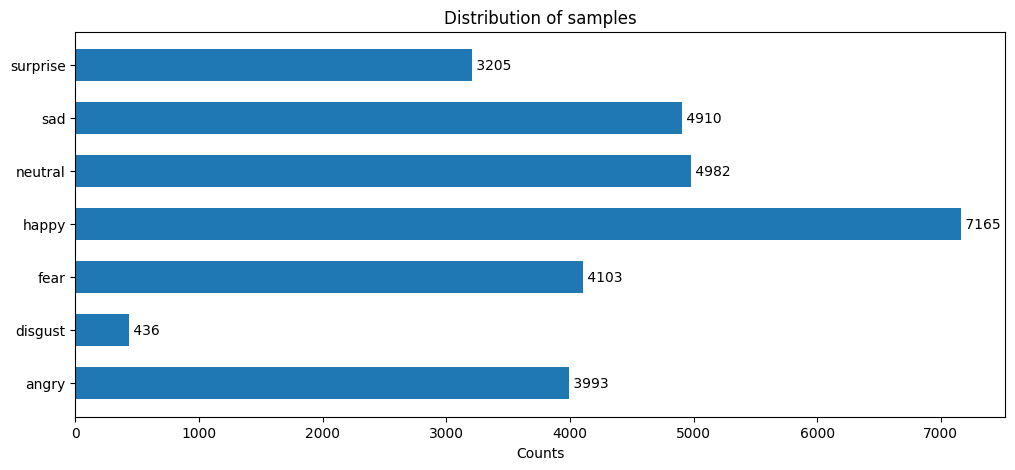

In [14]:

def plot_sample_distribution(labels):
    classes, cnts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(12, 5))
    plt.barh(list(emotions.values()), cnts, height=0.6)
    for i, v in enumerate(cnts):
        plt.text(v, i, ' '+str(v), va='center')
    plt.xlabel('Counts')
    plt.title("Distribution of samples")

plot_sample_distribution(labels)

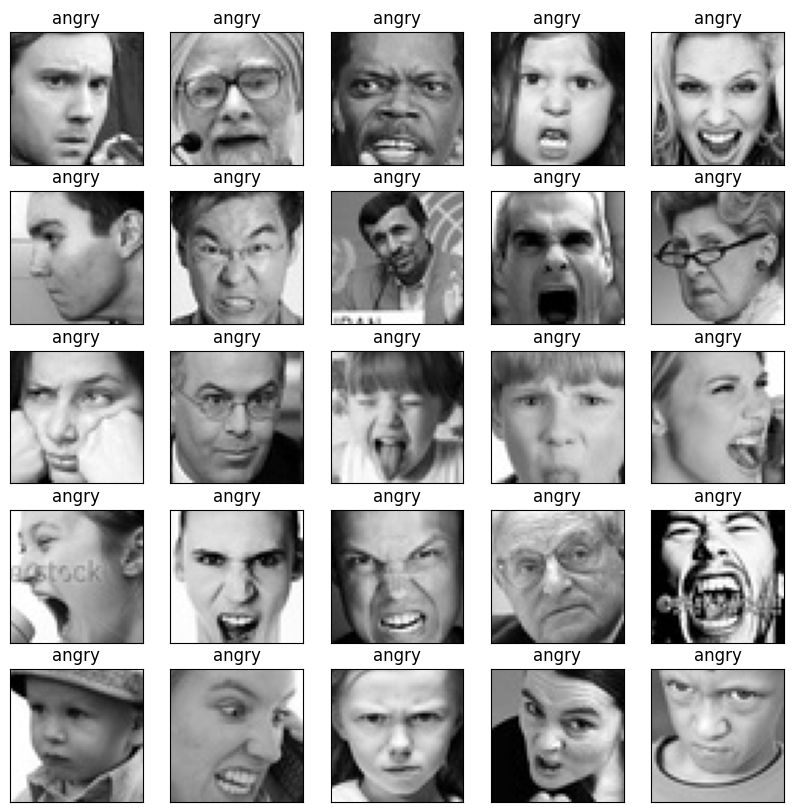

In [18]:

def show_images(images, labels, col=5):
    n = images.shape[0]
    row = int(np.ceil(n / col))
    fig = plt.figure(figsize=(2*col, 2*row))
    for i in range(n):
        fig.add_subplot(row, col, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(labels[i])
        plt.xticks([]), plt.yticks([])
    plt.show()

show_images(images[:25], labels[:25])
     

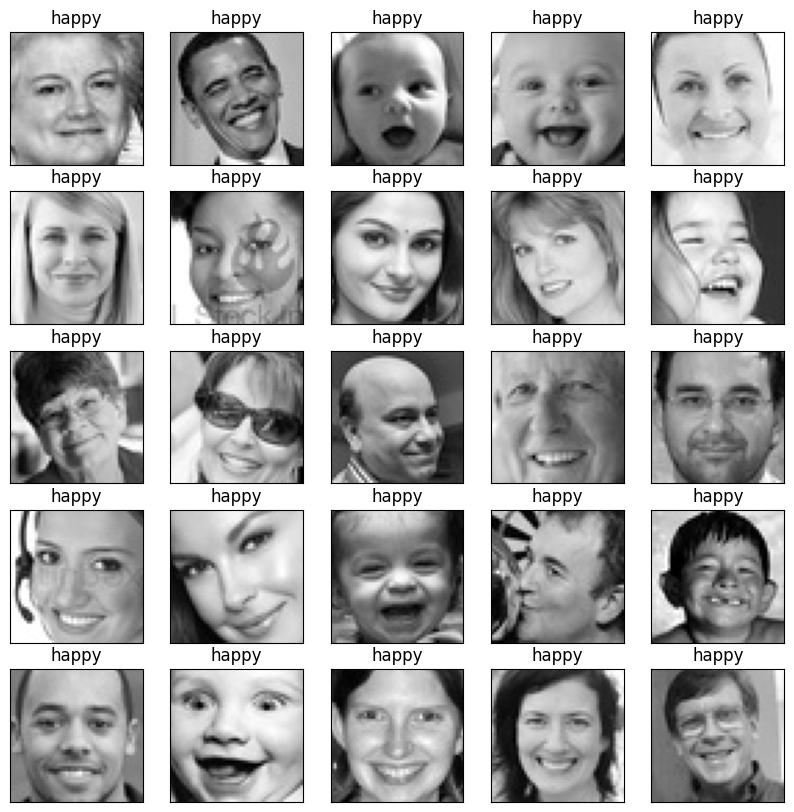

In [21]:

def show_one_emotion(images, labels, id, start=0, num=25):
    image_x = images[labels==id]
    label_x = labels[labels==id]
    show_images(image_x[start:start+num], label_x[start:start+num])

show_one_emotion(images, labels, id='happy')

# Split dataset

In [22]:
image_train, image_test, label_train, label_test = train_test_split(images, labels, test_size=0.2, random_state=42)
image_train, image_val, label_train, label_val = train_test_split(image_train, label_train, test_size=0.2, random_state=42)

print('Training samples:', label_train.shape[0])
print('Validation samples:', label_val.shape[0])
print('Test samples:', label_test.shape[0])

Training samples: 18428
Validation samples: 4607
Test samples: 5759


# Upsampling training data

# Utils

In [26]:

def reshape_images(images, channel=1, resize=None):
    x = tf.expand_dims(tf.convert_to_tensor(images), axis=3)
    if channel > 1:
        x = tf.repeat(x, channel, axis=3)
    if resize is not None:
        x = tf.image.resize(x, resize)
    return x
     

In [27]:
def pre_processing(images, labels, num_classes, channel=1, resize=None, one_hot=True):
    x = reshape_images(images, channel, resize)
    y = tf.keras.utils.to_categorical(labels, num_classes)
    return x, y

# Model

In [29]:

x_train, y_train = pre_processing(image_train, label_train, num_classes)
x_val, y_val = pre_processing(image_val, label_val, num_classes)
x_test, y_test = pre_processing(image_test, label_test, num_classes)


ValueError: ignored